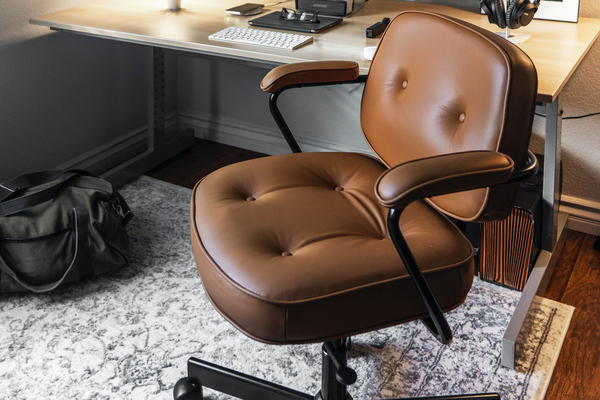

In [68]:
from IPython.display import clear_output, Image, display, HTML, Video
import ipywidgets
from base64 import b64encode
import cv2
import time

video_id = 'movie-9053391.mp4'
video_path = f'videos/{video_id}'

In [3]:
cap = cv2.VideoCapture(video_path)

display_handle=display(None, display_id=True)

image_widget = ipywidgets.Image(format='jpeg')

frame_id, frame_count = 0, 5
try:
    while True:
        clear_output(wait=True)
        _, frame = cap.read()
        image_widget.value = cv2.imencode('.jpeg', frame)[1].tobytes()
        display(image_widget)
        time.sleep(2)

        frame_id += 1
        if frame_id >= frame_count:
            break

except KeyboardInterrupt:
    pass
finally:
    cap.release()
    display_handle.update(None)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

### Load results from DynamoDB

In [78]:
# DynamoDB
table_name = 'octank_movie'

dynamodb = boto3.resource('dynamodb')

table = dynamodb.Table(table_name)

response = table.query(KeyConditionExpression=Key('video_id').eq(video_id))
                       
items = response['Items'][0]['detections']

items

{'44': [{'product_category': 'seasonal',
   'bbox': {'right': Decimal('2015'),
    'top': Decimal('806'),
    'left': Decimal('1413'),
    'bottom': Decimal('1205')},
   'product_id': 'aa28ecd4-29b6-479e-9093-b81275456c75'}],
 '45': [{'product_category': 'homedecor',
   'bbox': {'right': Decimal('2176'),
    'top': Decimal('443'),
    'left': Decimal('1575'),
    'bottom': Decimal('843')},
   'product_id': '9b752d29-c442-4347-b282-a9b0b77be1b2'}],
 '46': [{'product_category': 'accessories',
   'bbox': {'right': Decimal('2539'),
    'top': Decimal('335'),
    'left': Decimal('1939'),
    'bottom': Decimal('731')},
   'product_id': '55726766-f273-405b-b90c-c339a0d9609a'}],
 '47': [{'product_category': 'tools',
   'bbox': {'right': Decimal('2595'),
    'top': Decimal('1642'),
    'left': Decimal('1993'),
    'bottom': Decimal('2038')},
   'product_id': 'bb710911-1bba-4587-9bbe-65124d8495d0'}],
 '48': [{'product_category': 'apparel',
   'bbox': {'right': Decimal('1794'),
    'top': Decimal

In [42]:
#This function draws bbox on images
def draw_bbox(cv2, frame, bbox):
    
    top = bbox['top']
    left = bbox['left']
    bottom = bbox['bottom']
    right = bbox['right']
    
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 165, 255), 10)
    
    return frame

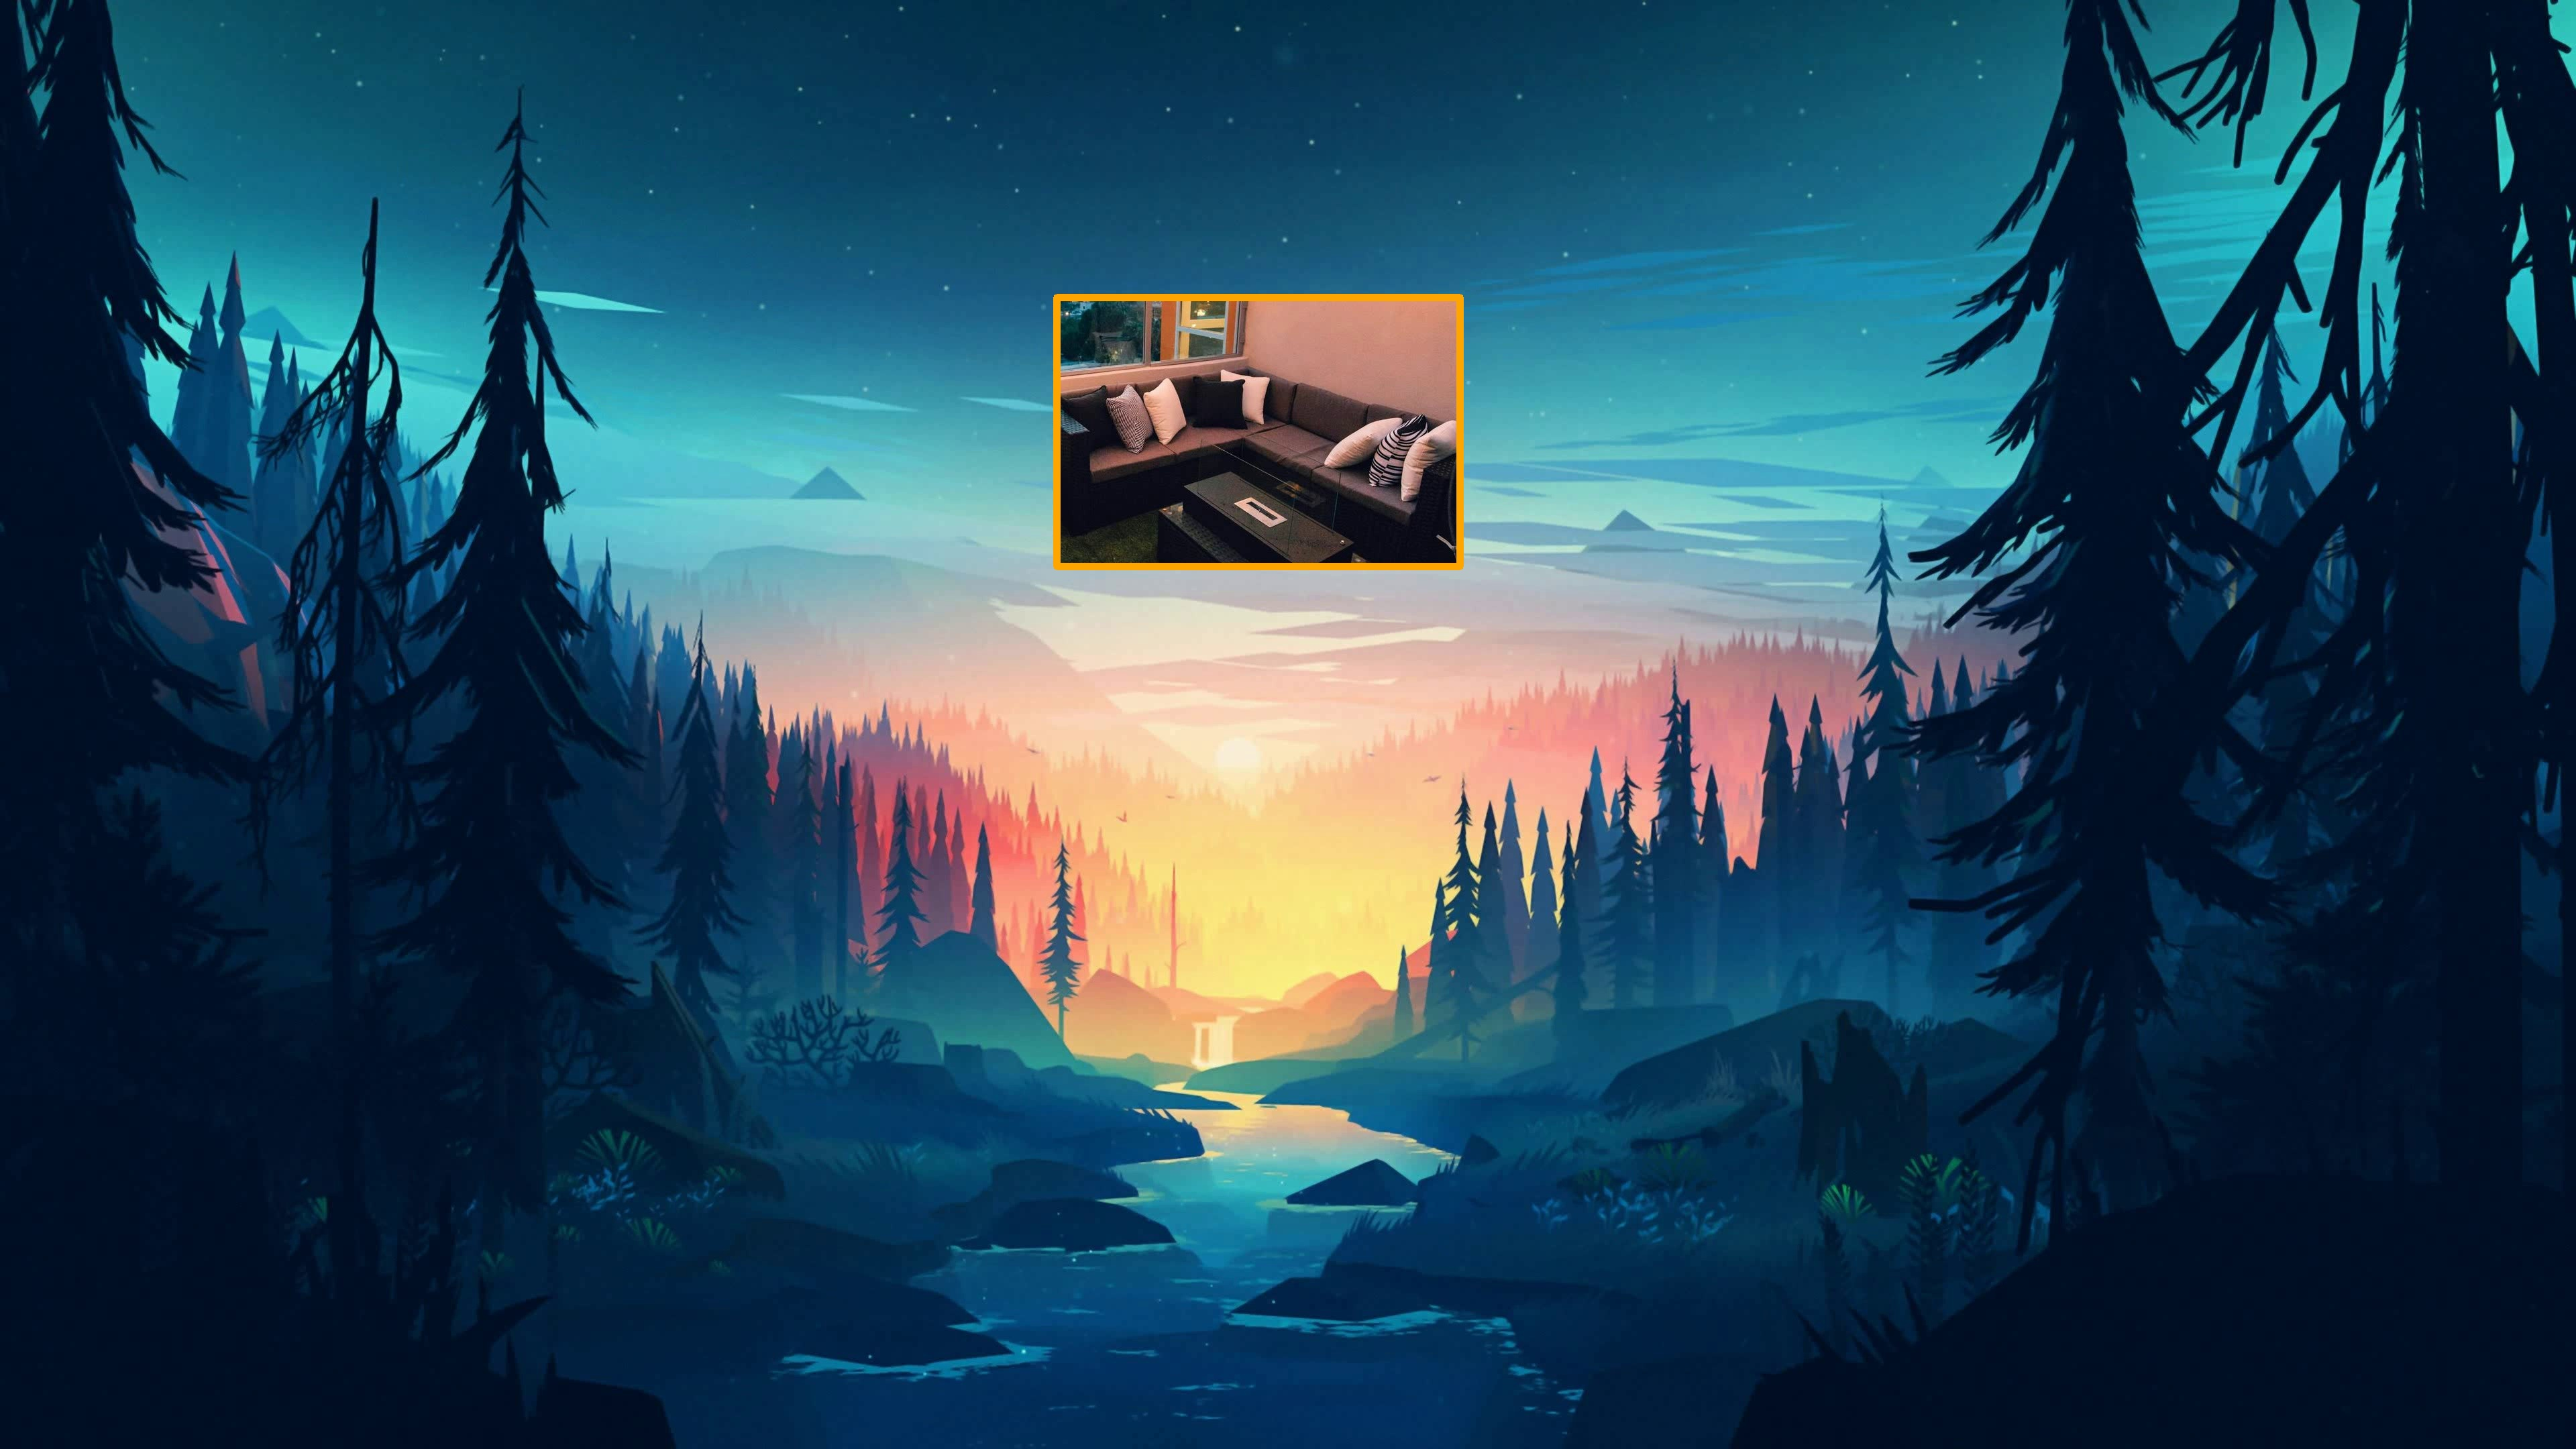

In [46]:
cap = cv2.VideoCapture(video_path)

frame_count = 2

frame_id = 0
display_handle=display(None, display_id=True)

while True:
    _, frame = cap.read()
    
    detections = items[str(frame_id)]
    for d in detections:
        frame = draw_bbox(cv2, frame, d['bbox'])
    
    frame_bytes = cv2.imencode('.jpeg', frame)[1].tobytes()

    display_handle.update(Image(data=frame_bytes))
    
    frame_id += 1
    if frame_id >= frame_count:
        break

In [79]:
from ipywidgets import interact, widgets, HBox, VBox, Layout, Box

from IPython.display import display

import boto3
from boto3.dynamodb.conditions import Key

cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

frame_id = 0

video_frames = []

# DynamoDB
table_name = 'octank_movie'

dynamodb = boto3.resource('dynamodb')

table = dynamodb.Table(table_name)

response = table.query(KeyConditionExpression=Key('video_id').eq(video_id))
                       
items = response['Items'][0]['detections']

product_ids = []
product_categories = []

while True:
    _, frame = cap.read()
    
    p_id = ''
    p_category = ''
    detections = items[str(frame_id)]
    for d in detections:
        frame = draw_bbox(cv2, frame, d['bbox'])
        p_id = d['product_id']
        p_category = d['product_category']
        
    
    frame_bytes = cv2.imencode('.jpeg', frame)[1].tobytes()

    video_frames.append(frame_bytes)
    product_ids.append(p_id)
    product_categories.append(p_category)
    
    frame_id += 1
    if frame_id >= frame_count:
        break

In [81]:
box_layout = Layout(
                    display='flex',
                    flex_flow='column',
                    width='200%')

vbox1 = VBox(children=[widgets.Image(value=video_frames[0])], layout=box_layout)

vbox2 = VBox(children=[widgets.Image(value=Image(product_image_url.format(product_categories[0],
                                                                          product_ids[0])).data),
                      widgets.Label(f"product_id: {product_ids[0]}"),
                      widgets.Label(f"product_category: {product_categories[0]}")])
        
def f(Frame_numb):
    i = Frame_numb-1
    image = video_frames[i]
    vbox1 = VBox(children=[widgets.Image(value=image)], layout=box_layout)
    vbox2 = VBox(children=[widgets.Image(value=Image(product_image_url.format(product_categories[i],
                                                                          product_ids[i])).data),
                      widgets.Label(f"product_id: {product_ids[i]}"),
                      widgets.Label(f"product_category: {product_categories[i]}")])
    hbox = HBox([vbox1, vbox2])
    display(hbox)
    
hbox = HBox([vbox1, vbox2])

play = widgets.Play(
    value=1,
    min=1,
    max=frame_count,
    step=1,
    interval=2000,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider(min=1,max=frame_count,step=1,value=1)
widgets.jslink((play, 'value'), (slider, 'value'))
ui = widgets.HBox([play, slider])

output = widgets.interactive_output(f, {'Frame_numb': play})
display(ui, output)

Output()